In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import pickle

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
q1.ef_amp = 0.5
print(f"{q1}\n{q2}")

Qubit(ro_freq=6.72739, ef_half_amp_y=1.65, ef_time=44, ge_amp=1.01, qubit_thr=[-10000, -600], qubit_id=q1, mixer_offset_ge=2.5, ef_half_time=22, mixer_offset_ef=6, ef_ssm=-0.2581, RO_IF=None, IQ_angle=110, ROIF=0.10268999999999995, ge_time=77, RO_LO=6.6247, ro_dur=5000, ef_half_amp_x=1.67, ge_ssm=-0.1144, ef_amp=0.5, RO_LO_pwr=16, ro_amp=0.35)
Qubit(ro_freq=6.65554, ef_half_amp_y=None, ef_time=None, ge_amp=0.8, qubit_thr=[-10000, 1900], qubit_id=q2, mixer_offset_ge=None, ef_half_time=None, mixer_offset_ef=None, ef_ssm=-0.2962, RO_IF=None, IQ_angle=25, ROIF=0.030840000000000423, ge_time=74, RO_LO=6.6247, ro_dur=5000, ef_half_amp_x=None, ge_ssm=-0.154, ef_amp=1, RO_LO_pwr=16, ro_amp=0.5)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [4]:
def run_rabi(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ef(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df


def run_ssm_sweep(
    freq_start, freq_stop, freq_steps, reps, sweep_time, filename="ssm_sweep_on_res.pkl"
):
    """
    Run an SSM sweep by performing Rabi experiments at each frequency.
    Save results to a file after each step.
    """
    frequencies = np.linspace(freq_start, freq_stop, freq_steps)
    num_steps = 51  # Number of time steps for Rabi oscillation
    q1.ef_amp=0.025
    # Initialize arrays to store results
    I_1, Q_1, I_2, Q_2 = np.zeros((4, freq_steps, num_steps))

    for i, freq in enumerate(frequencies):
        # Set the SSM frequency for qubit 1
        q1.ef_ssm = freq
        # Check if the file exists
        if os.path.exists(filename):
            print(f"Loading existing data from {filename}...")
            with open(filename, "rb") as f:
                saved_data = pickle.load(f)

            # Load saved data
            I_1 = saved_data["I_1"]
            Q_1 = saved_data["Q_1"]
            I_2 = saved_data["I_2"]
            Q_2 = saved_data["Q_2"]
            last_completed_step = saved_data["last_completed_step"]

            print(f"Resuming from step {last_completed_step + 1}/{freq_steps}")
        else:
            last_completed_step = -1  # Start from the beginning
        # Run Rabi experiment
        values, IQ_df = run_rabi(q1, q2, general_vals_dict, num_steps, sweep_time, reps)

        # Extract averaged I and Q values
        I_Q1 = values.rec_avg_vs_pats_1[0]
        Q_Q1 = values.rec_avg_vs_pats_1[1]
        I_Q2 = values.rec_avg_vs_pats_2[0]
        Q_Q2 = values.rec_avg_vs_pats_2[1]

        # Store results
        I_1[i] = I_Q1
        Q_1[i] = Q_Q1
        I_2[i] = I_Q2
        Q_2[i] = Q_Q2

        # Save results to file after each step
        with open(filename, "wb") as f:
            pickle.dump(
                {
                    "frequencies": frequencies,
                    "I_1": I_1,
                    "Q_1": Q_1,
                    "I_2": I_2,
                    "Q_2": Q_2,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{freq_steps} --------------------")

    return I_1, Q_1, I_2, Q_2


def run_amp_sweep(
    amp_start, amp_stop, amp_steps, reps, sweep_time, filename="ef_amp_sweep.pkl"
):
    """
    Run an amplitude sweep by performing Rabi experiments at the resonant frequency.
    Save results to a file after each step. If the file already exists, restart from the last completed step.
    """
    amplitudes = np.linspace(amp_start, amp_stop, amp_steps)
    num_steps = 51  # Number of time steps for Rabi oscillation

    # Initialize arrays to store results
    I_1, Q_1, I_2, Q_2 = np.zeros((4, amp_steps, num_steps))

    # Check if the file exists
    if os.path.exists(filename):
        print(f"Loading existing data from {filename}...")
        with open(filename, "rb") as f:
            saved_data = pickle.load(f)

        # Load saved data
        I_1 = saved_data["I_1"]
        Q_1 = saved_data["Q_1"]
        I_2 = saved_data["I_2"]
        Q_2 = saved_data["Q_2"]
        last_completed_step = saved_data["last_completed_step"]

        print(f"Resuming from step {last_completed_step + 1}/{amp_steps}")
    else:
        last_completed_step = -1  # Start from the beginning

    # Run the sweep
    for i in range(last_completed_step + 1, amp_steps):
        amp = amplitudes[i]

        # Set the amplitude for qubit 1
        q1.ef_amp = amp

        # Run Rabi experiment
        values, IQ_df = run_rabi(q1, q2, general_vals_dict, num_steps, sweep_time, reps)

        # Extract averaged I and Q values
        I_Q1 = values.rec_avg_vs_pats_1[0]
        Q_Q1 = values.rec_avg_vs_pats_1[1]
        I_Q2 = values.rec_avg_vs_pats_2[0]
        Q_Q2 = values.rec_avg_vs_pats_2[1]

        # Store results
        I_1[i] = I_Q1
        Q_1[i] = Q_Q1
        I_2[i] = I_Q2
        Q_2[i] = Q_Q2

        # Save results to file after each step
        with open(filename, "wb") as f:
            pickle.dump(
                {
                    "amplitudes": amplitudes,
                    "I_1": I_1,
                    "Q_1": Q_1,
                    "I_2": I_2,
                    "Q_2": Q_2,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{amp_steps} --------------------")

    return I_1, Q_1, I_2, Q_2


def plot_chevron_freq(I_1, Q_1, frequencies, sweep_time, freq_start, freq_stop):
    """
    Plot the Rabi chevron results for I and Q channels of both qubits.
    """
    # Find resonant frequencies
    min_index_I1 = np.unravel_index(np.argmin(I_1), I_1.shape)
    min_index_Q1 = np.unravel_index(np.argmin(Q_1), Q_1.shape)
    rf_I1 = frequencies[min_index_I1[0]]
    rf_Q1 = frequencies[min_index_Q1[0]]

    # Plot I_1
    plt.figure()
    plt.imshow(I_1, extent=[0, sweep_time / 1000, freq_stop, freq_start], aspect="auto")
    plt.colorbar(label="I_1")
    plt.axhline(
        y=rf_I1, color="black", linestyle="--", label=f"Resonance: {rf_I1:.4f} GHz"
    )
    plt.ylabel("Frequency (GHz)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 I-channel Chevron")
    plt.legend()
    plt.show()

    # Plot Q_1
    plt.figure()
    plt.imshow(Q_1, extent=[0, sweep_time / 1000, freq_stop, freq_start], aspect="auto")
    plt.colorbar(label="Q_1")
    plt.axhline(
        y=rf_Q1, color="black", linestyle="--", label=f"Resonance: {rf_Q1:.4f} GHz"
    )
    plt.ylabel("Frequency (GHz)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 Q-channel Chevron")
    plt.legend()
    plt.show()


def plot_chevron_amp(I_1, Q_1, amplitudes, sweep_time, amp_start, amp_stop):
    """
    Plot the Rabi chevron results for I and Q channels, varying amplitude instead of frequency.
    """
    # Find resonant amplitudes
    min_index_I1 = np.unravel_index(np.argmax(I_1), I_1.shape)
    min_index_Q1 = np.unravel_index(np.argmax(Q_1), Q_1.shape)
    ra_I1 = amplitudes[min_index_I1[0]]  # Resonant amplitude for I
    ra_Q1 = amplitudes[min_index_Q1[0]]  # Resonant amplitude for Q

    # Plot I_1
    plt.figure()
    plt.imshow(I_1, extent=[0, sweep_time / 1000, amp_stop, amp_start], aspect="auto")
    plt.colorbar(label="I_1")
    plt.axhline(
        y=ra_I1,
        color="black",
        linestyle="--",
        label=f"Resonance: {ra_I1:.3f} (arb. units)",
    )
    plt.ylabel("Amplitude (arb. units)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 I-channel Chevron (Amplitude Sweep)")
    plt.legend()
    plt.show()

    # Plot Q_1
    plt.figure()
    plt.imshow(Q_1, extent=[0, sweep_time / 1000, amp_stop, amp_start], aspect="auto")
    plt.colorbar(label="Q_1")
    plt.axhline(
        y=ra_Q1,
        color="black",
        linestyle="--",
        label=f"Resonance: {ra_Q1:.3f} (arb. units)",
    )
    plt.ylabel("Amplitude (arb. units)")
    plt.xlabel("Time (µs)")
    plt.title("Qubit 1 Q-channel Chevron (Amplitude Sweep)")
    plt.legend()
    plt.show()

In [5]:
amp_start = 0.1
amp_stop = 31
amp_steps = 130


reps = 2000
sweep_time = 2000
freq_res = q1.ef_ssm
freq_diff = -0.1
freq_start = -0.256
freq_stop = -0.259
freq_steps = 31


I_1, Q_1, _, _ = run_ssm_sweep(freq_start, freq_stop, freq_steps, reps, sweep_time)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.100364 sec
Captured 34 buffers (3.062963 buffers per sec)
Captured 104448 records (9409.421396 records per sec)
Transferred 1711276032 bytes (154163960.155799 bytes per sec)
------------- Done with 1/31 --------------------
Loading existing data from ssm_sweep_on_res.pkl...
Resuming from step 1/31
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
w

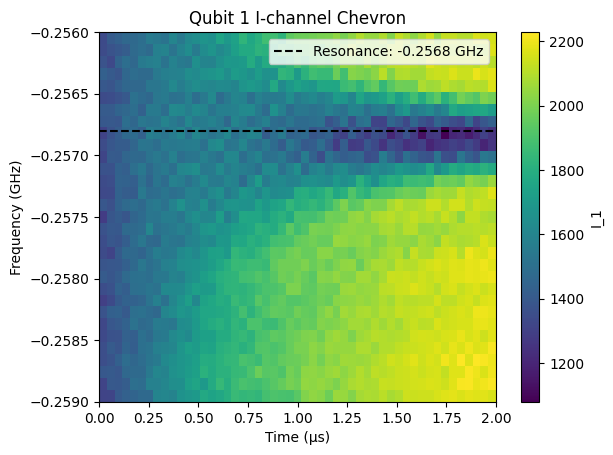

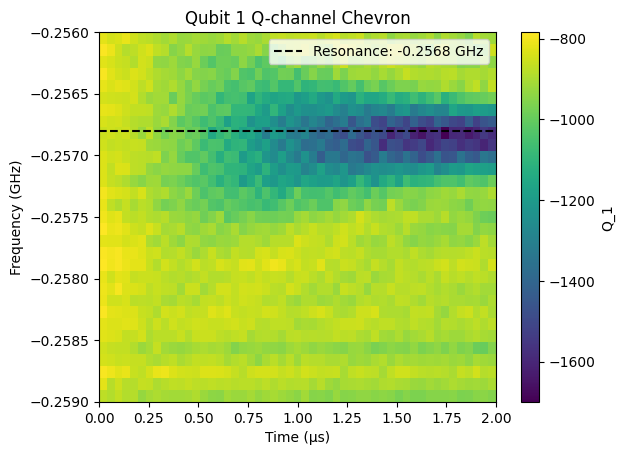

In [6]:
frequencies = np.linspace(freq_start, freq_stop, freq_steps)
amplitudes = np.linspace(amp_start, amp_stop, amp_steps)
plot_chevron_freq(I_1, Q_1, frequencies, sweep_time, freq_start, freq_stop)